# Import Statements

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gzip
from tqdm import tqdm

# Read Files

In [2]:
def images_file_read(file_name):
    with gzip.open(file_name, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images

In [3]:
def labels_file_read(file_name):
    with gzip.open(file_name, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [4]:
train_x = images_file_read('Dataset/mnist/train-images-idx3-ubyte.gz')
print(train_x.shape)

(60000, 28, 28)


In [5]:
train_x = np.reshape(train_x, (60000,784))
print(train_x.shape)

(60000, 784)


In [6]:
train_y = labels_file_read('Dataset/mnist/train-labels-idx1-ubyte.gz')
print(train_y.shape)

(60000,)


In [7]:
test_x = images_file_read('Dataset/mnist/t10k-images-idx3-ubyte.gz')
print(test_x.shape)

(10000, 28, 28)


In [8]:
test_x = np.reshape(test_x, (10000,784))
print(test_x.shape)

(10000, 784)


In [9]:
test_y = labels_file_read('Dataset/mnist/t10k-labels-idx1-ubyte.gz')
print(test_y.shape)

(10000,)


# Gradient Boosting Classifier

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [11]:
def gradient_boosting(train_x, train_y, test_x, test_y, num_of_iterations, learning_rate, max_depth_of_decision_tree_regresssor):
    models = []
    train_vs_itr_scores = []
    train_vs_itr_accuracy = []
    residuals = []
    combined_predictions = []
    
    # Initial Model
    Fx = DecisionTreeRegressor(max_depth=max_depth_of_decision_tree_regresssor, random_state=0)
    Fx.fit(train_x, train_y)
    Fx_predictions = Fx.predict(train_x)
    train_vs_itr_scores.append(r2_score(train_y, Fx_predictions))
    base_predictions_rounded_off = np.rint(Fx_predictions).astype('int')
    base_correct_pred = 0
    for x in range(len(base_predictions_rounded_off)):
        if train_y[x] == base_predictions_rounded_off[x]:
            base_correct_pred += 1
    train_vs_itr_accuracy.append(base_correct_pred/len(base_predictions_rounded_off))
    models.append(Fx)
    
    # Initializing for Iterations
    residuals.append(train_y)
    combined_predictions.append(Fx_predictions)
    
    # Additional Models
    for itr in range(1, num_of_iterations+1):
        current_residual = residuals[itr-1] - models[itr-1].predict(train_x)
        residuals.append(current_residual)
        hx = DecisionTreeRegressor(max_depth=max_depth_of_decision_tree_regresssor, random_state=0)
        hx.fit(train_x, current_residual)
        hx_predictions = hx.predict(train_x)
        combined_predictions.append(combined_predictions[itr-1] + hx_predictions)
        train_vs_itr_scores.append(r2_score(train_y, combined_predictions[itr]))
        current_predictions_rounded_off = np.rint(combined_predictions[itr]).astype('int')
        correct_pred = 0
        for x in range(len(current_predictions_rounded_off)):
            if train_y[x] == current_predictions_rounded_off[x]:
                correct_pred += 1
        train_vs_itr_accuracy.append(correct_pred/len(current_predictions_rounded_off))
        models.append(hx)
    
    return models, train_vs_itr_scores, train_vs_itr_accuracy

In [12]:
def test_score_accuracy(test_x, test_y, models, num_of_iterations, learning_rate):
    test_pred = []
    test_pred.append(models[0].predict(test_x))
    
    for i in range(1, num_of_iterations+1):
        pred = test_pred[i-1] + learning_rate*models[i].predict(test_x)
        test_pred.append(pred)
    final_test_pred = test_pred[num_of_iterations]
    final_test_pred_rounded_off = np.rint(final_test_pred).astype('int')
    
    final_test_score = r2_score(test_y, final_test_pred)
    correct_pred = 0
    for x in range(len(final_test_pred_rounded_off)):
        if test_y[x] == final_test_pred_rounded_off[x]:
            correct_pred += 1
    final_test_accuracy = correct_pred/len(final_test_pred_rounded_off)
    
    return final_test_score, final_test_accuracy

In [13]:
# num_of_iterations = [5, 10, 15]
# learning_rates = [0.1, 0.5, 1]
# max_depths = [1, 2, 5]
# best_case = (0,0,0)
# best_train_score = 0.0

# for i in range(len(num_of_iterations)):
#     for j in range(len(learning_rates)):
#         for k in range(len(max_depths)):
#             models, train_vs_itr_scores, train_vs_itr_accuracy = gradient_boosting(train_x, train_y, test_x, test_y, num_of_iterations[i], learning_rates[j], max_depths[k])
#             print('Case ({}, {}, {}): Training Score: {} Training Accuracy: {}%'.format(num_of_iterations[i], learning_rates[j], max_depths[k], train_vs_itr_scores[num_of_iterations[i]], 100*train_vs_itr_accuracy[num_of_iterations[i]]))
#             if(train_vs_itr_scores[num_of_iterations[i]] > best_train_score):
#                 best_train_score = train_vs_itr_scores[num_of_iterations[i]]
#                 best_train_accuracy = train_vs_itr_accuracy[num_of_iterations[i]]
#                 best_case = (num_of_iterations[i], learning_rates[j], max_depths[k])

# print('Best Case - Number of Iterations: {}, Learning Rate: {}, Max Depth of Decision Tree Regressor: {}'.format(best_case[0], best_case[1], best_case[2]))

# Save Best Model

In [14]:
# models, train_vs_itr_scores, train_vs_itr_accuracy = gradient_boosting(train_x, train_y, test_x, test_y, best_case[0], best_case[1], best_case[2])

# data = {}
# data['models'] = models
# data['train_vs_itr_scores'] = train_vs_itr_scores
# data['train_vs_itr_accuracy'] = train_vs_itr_accuracy
# data['best_case'] = best_case

In [15]:
# pi_file = open('Q1_pkl_file.pkl', 'wb')
# pickle.dump(data, pi_file)
# pi_file.close()

# Load Best Model

In [16]:
pi_file = open('Q1_pkl_file.pkl', 'rb')
best_data = pickle.load(pi_file)
pi_file.close()

# Train vs Iterations Plot for Best Model

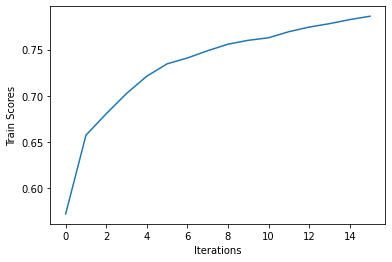

In [17]:
plt.xlabel('Iterations')
plt.ylabel('Train Scores')
plt.plot(best_data['train_vs_itr_scores'])
plt.show()

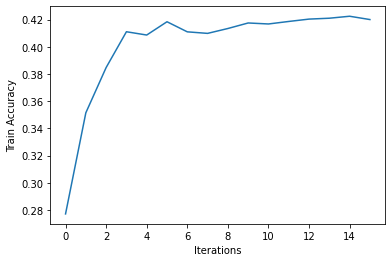

In [18]:
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')
plt.plot(best_data['train_vs_itr_accuracy'])
plt.show()

# Test Score & Accuracy Of Best Model

In [19]:
final_test_score, final_test_accuracy = test_score_accuracy(test_x, test_y, best_data['models'], best_data['best_case'][0], best_data['best_case'][1])
print('Test Score: {}'.format(final_test_score))
print('Test Accuracy: {}%'.format(final_test_accuracy*100))

Test Score: 0.6387846841253644
Test Accuracy: 32.39%
